In [1]:
from lsst_efd_client import EfdClient
from lsst.ts import salobj

import asyncio
import numpy as np
import os
import time

from astropy.io import fits
import matplotlib.pyplot as plt

from scipy import interpolate

from astropy.time import Time, TimeDelta
import pandas as pd

from scipy import stats

In [2]:
client = EfdClient('tucson_teststand_efd')

In [3]:
ScanData_600nm_filen = '/home/parfa30/DATA/ScanData/600nm_full_scan_na12_2022-05-20T19:18:40.397.csv'
ScanData_600nm_filen_2 = '/home/parfa30/DATA/ScanData/600nm_full_scan_final_2022-05-20T22:40:54.161.csv'
ScanData_600nm_filen_3 = '/home/parfa30/DATA/ScanData/600nm_full_scan_2022-05-23T19:45:03.563.csv'
ScanData_600nm_filen_4 = '/home/parfa30/DATA/ScanData/600nm_full_scan_2022-05-24T16:38:00.032.csv'
ScanData_600nm_filen_5 = '/home/parfa30/DATA/ScanData/600nm_full_scan_2_2022-05-24T17:33:33.605.csv'
ScanData_600nm_filen_6 = '/home/parfa30/DATA/ScanData/600nm_full_scan_no_filter_2022-05-25T16:19:17.434.csv'
#StabilityData_600nm_filen = '/home/parfa30/DATA/ScanData/600nm_stability_scan_na12_2022-05-20T19:33:09.871.csv'
#StabilityData_600nm_filen_2 ='/home/parfa30/DATA/ScanData/600nm_stability_scan_final_2022-05-20T22:54:50.983.csv'
StabilityData_600nm_filen_3 = '/home/parfa30/DATA/ScanData/600nm_stability_scan_final_2022-05-23T19:58:05.539.csv'
StabilityData_600nm_filen_5 = '/home/parfa30/DATA/ScanData/600nm_stability_scan_2022-05-24T18:35:47.230.csv'
StabilityData_600nm_filen_6 = '/home/parfa30/DATA/ScanData/600nm_stability_scan_no_filter_2022-05-25T16:54:49.438.csv'

ScanData_600nm_scrambler_filen = '/home/parfa30/DATA/ScanData/600nm_center_scan_scrambler_2022-05-31T23:49:49.449.csv'
ScanData_600nm_scrambler_filen_2 ='/home/parfa30/DATA/ScanData/600nm_center_scan_scrambler_2022-06-01T18:07:39.468.csv'

ScanData_800nm_filen = '/home/parfa30/DATA/ScanData/800nm_full_scan_2022-05-21T00:04:35.038.csv'
#StabilityData_800nm_filen = '/home/parfa30/DATA/ScanData/800nm_stability_scan_final_2022-05-21T00:22:00.896.csv'

ScanData_450nm_filen = '/home/parfa30/DATA/ScanData/450nm_full_scan_2022-05-23T18:09:39.265.csv'
#StabilityData_450nm_filen = '/home/parfa30/DATA/ScanData/450nm_stability_scan_final_2022-05-23T18:22:15.903.csv'

In [4]:
ScanData_LED_file = '/home/parfa30/DATA/ScanData/445nm_full_scan_LED_2022-05-31T04:20:37.336.csv'
ScanData_center_scan = '/home/parfa30/DATA/ScanData/600nm_center_scan_scrambler_2022-05-31T21:49:25.942.csv'
StabilityData_600nm_scramble = '/home/parfa30/DATA/ScanData/600nm_stability_scan_scrambler_2022-05-31T22:00:43.168.csv'

In [5]:
import subprocess
dir_ = '/home/parfa30/DATA/electrometer_files'
def transfer_file(filen):
    bashCommand = "scp saluser@toonie.tu.lsst.org:/home/saluser/develop/electrometerFitsFiles/{} {}".format(filen, dir_)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

In [6]:
def get_y_func(stage_df):
    y = stage_df[stage_df.LinearStageID == 2]
    f = interpolate.interp1d(list(y.index.to_julian_date()), list(y['position']), fill_value='extrapolate',bounds_error=False)
    return f

In [7]:
def get_x_func(stage_df):
    x = stage_df[stage_df.LinearStageID == 1]
    f = interpolate.interp1d(list(x.index.to_julian_date()), list(x['position']), fill_value='extrapolate',bounds_error=False)
    return f

In [8]:
async def get_efd_data(start_time, end_time):
    elec_log_topic = 'lsst.sal.Electrometer.logevent_logMessage'
    elec_df = await client.select_time_series(elec_log_topic,['ElectrometerID','functionName','message'], start=start_time, end=end_time)
    elec_df.sort_index(inplace=True)
    stage_log_topic = 'lsst.sal.LinearStage.position'
    stage_df = await client.select_time_series(stage_log_topic,['LinearStageID','position'],start=start_time, end=end_time)
    stage_df.sort_index(inplace=True)
    
    return elec_df, stage_df

In [9]:
x_offset = {2:0,4:-200,5:-400}

In [67]:
def get_elec_data(elec_df, y_pos_func, scan_row):
    x = elec_df[(elec_df.functionName == 'write_fits_file')]
    D = []
    for i, row in x.iterrows():
        if 'data file' in row.message:
            xpos = scan_row['xpos'] + x_offset[int(row['ElectrometerID'])] #
            filen = row.message.split(' ')[-1]
            start_time, end_time = os.path.splitext(filen)[0].split('_')
            transfer_file(filen)
            ff = os.path.join(dir_, filen)
            data = fits.open(ff)[0].data
            for ii, t in enumerate(list(data[0])):
                tt = t + float(start_time) - 37
                tt = Time(tt, scale='tai',format='unix_tai')
                if isinstance(y_pos_func,float):
                    ypos = y_pos_func
                else:
                    ypos = y_pos_func(tt.jd)
                D.append([scan_row['start_time'],scan_row['end_time'],row['ElectrometerID'],filen, tt.datetime, xpos,ypos, np.array(data[1])[ii], scan_row['step'],scan_row['total_steps'],scan_row['test_name'], scan_row['wave']])
    return D

In [11]:
def get_elec_data_x(elec_df, x_pos_func, scan_row):
    x = elec_df[(elec_df.functionName == 'write_fits_file')]
    D = []
    for i, row in x.iterrows():
        if 'data file' in row.message:
            
            filen = row.message.split(' ')[-1]
            start_time, end_time = os.path.splitext(filen)[0].split('_')
            start = Time(float(start_time)-37, scale='tai',format='unix_tai').datetime
            end = Time(float(end_time)-37, scale='tai',format='unix_tai').datetime
            transfer_file(filen)
            ff = os.path.join(dir_, filen)
            data = fits.open(ff)[0].data
            for ii, t in enumerate(list(data[0])):
                tt = t + float(start_time) - 37
                tt = Time(tt, scale='tai',format='unix_tai')
                if isinstance(x_pos_func,float):
                    xpos = x_pos_func    
                else:
                    xpos = x_pos_func(tt.jd)
                    xpos = xpos + x_offset[int(row['ElectrometerID'])]
                D.append([scan_row['start_time'],scan_row['end_time'],row['ElectrometerID'],filen, tt.datetime, xpos,700, np.array(data[1][::-1])[ii], scan_row['test_name'], scan_row['wave']])
    return D

In [23]:
#Full Scan
ScanData = pd.read_csv(ScanData_600nm_scrambler_filen)
FinalData = []
for i, row in ScanData.iterrows():
    try:
        elec_df, stage_df = await get_efd_data(Time(row['start_time']),Time(row['end_time']))
        y_pos_func = get_y_func(stage_df) 
        D = get_elec_data(elec_df, y_pos_func, row)
        new_df = pd.DataFrame(D, columns = ['start_time','end_time','Electrometer','filename','meas_time','xpos','ypos','amps','step','total_steps','test_name','wave'])
        FinalData.append(new_df)
    except:
        print('failed',row['start_time'],row['end_time'],row['step'])

failed 2022-05-31 22:09:59.033079 2022-05-31 22:11:04.917886 0


In [86]:
#Center Scan
ScanData = pd.read_csv(ScanData_600nm_scrambler_filen_2)
FinalData = []
for i, row in ScanData.iterrows():
    try:
        elec_df, stage_df = await get_efd_data(Time(row['start_time']),Time.now())#(row['end_time']))
        x_pos_func = get_x_func(stage_df) 
        D = get_elec_data_x(elec_df, x_pos_func, row)
        new_df = pd.DataFrame(D, columns = ['start_time','end_time','Electrometer','filename','meas_time','xpos','ypos','amps','test_name','wave'])
        FinalData.append(new_df)
    except:
        print('failed',row)

In [68]:
#Stability Scan
StabilityData = pd.read_csv(StabilityData_600nm_scramble)
FinalData = []
for i, row in StabilityData.iterrows():
    try:
        elec_df, stage_df = await get_efd_data(Time(row['start_time']),Time(row['end_time']))
        D = get_elec_data(elec_df, float(1000), row)
        new_df = pd.DataFrame(D, columns = ['start_time','end_time','Electrometer','filename','meas_time','xpos','ypos','amps','step','total_steps','test_name','wave'])
        FinalData.append(new_df)
    except:
        print(row)

xpos                           1000.01001
ypos                           701.099976
start_time     2022-05-31 21:54:39.500904
end_time       2022-05-31 21:55:30.588543
step                                    0
total_steps                             5
test_name        stability_scan_scrambler
wave                                  600
Name: 0, dtype: object


In [44]:
Time(min(StabilityData.start_time)), Time(max(StabilityData.end_time))

(<Time object: scale='utc' format='iso' value=2022-05-31 21:54:39.501>,
 <Time object: scale='utc' format='iso' value=2022-05-31 22:00:13.563>)

In [69]:
FinalData = pd.concat(FinalData)
FinalData.reset_index(inplace=True)

In [70]:
save_filen = '{}.csv'.format('600nm_stability_scramble_jun1')
print(os.path.join('/home/parfa30/DATA/ScanData',save_filen))
FinalData.to_csv(os.path.join('/home/parfa30/DATA/ScanData',save_filen),index=False)

/home/parfa30/DATA/ScanData/600nm_stability_scramble_jun1.csv


In [18]:
FinalData_600_0 = pd.read_csv(os.path.join('/home/parfa30/DATA/ScanData','600nm_full_scan_2_2022-05-19T18:23:45.727.csv'))
FinalData_600_1 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_full_scan_na12_may20.csv')
FinalData_600_2 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_full_scan_final_may20.csv')
FinalData_600_3 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_full_scan_may23.csv')
FinalData_600_4 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_full_scan_may24.csv')
FinalData_600_5 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_full_scan_2_may24.csv')
FinalData_600_6 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_full_scan_may25.csv')
FinalData_800 = pd.read_csv('/home/parfa30/DATA/ScanData/800nm_full_scan_may20.csv')
FinalData_450 = pd.read_csv('/home/parfa30/DATA/ScanData/450nm_full_scan_may23.csv')

In [71]:
FinalData_600_Center = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_center_scan_may31.csv')
FinalData_600_Center_Scramble = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_center_scan_scrambler.csv')
FinalData_600_Center_Scramble_2 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_center_scan_scramble_jun1.csv')
FinalData_600_scramble = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_stability_scramble_jun1.csv')

In [27]:
pd_response = pd.read_csv('hamamatsu_responsivity.csv')
area = 100 #mm2
amps_per_watt = float(pd_response[pd_response.wavelength == 440].responsivity)                        
             
def watts_per_mm2(amps):  
    watts_per_mm2 = (amps/amps_per_watt)/area
    return watts_per_mm2                             
   

Text(0.5, 1.0, 'May 31 @ 600nm')

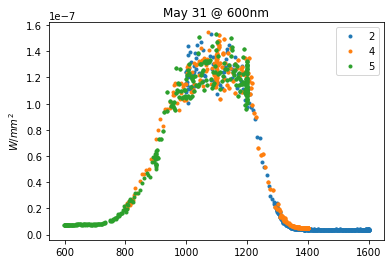

In [68]:
for elec in [2,4,5]:
    df_ = FinalData_600_Center[FinalData_600_Center.Electrometer==elec]
    plt.plot(df_.xpos,watts_per_mm2(df_.amps*-1),'.',label=elec)
plt.legend()
plt.ylabel("$W/mm^{2}$")
plt.title('May 31 @ 600nm')

Text(0.5, 1.0, 'June 1 @ 600nm')

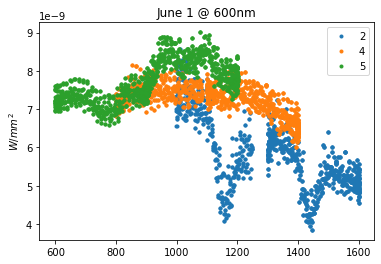

In [95]:
for elec in [2,4,5]:
    df_ = FinalData_600_Center_Scramble_2[FinalData_600_Center_Scramble_2.Electrometer==elec]
    plt.plot(df_.xpos,watts_per_mm2(df_.amps*-1),'.',label=elec)
plt.legend()
plt.ylabel("$W/mm^{2}$")
plt.title('June 1 @ 600nm')

In [31]:
f0 = FinalData_600_0[(FinalData_600_0.ypos <1500)&(FinalData_600_0.step>0)]
f1 = FinalData_600_1[(FinalData_600_1.ypos<1500)&(FinalData_600_1.step >0)&(FinalData_600_1.amps <0)]
f2 = FinalData_600_2[(FinalData_600_2.ypos >300)&(FinalData_600_2.step >0)]
f3 = FinalData_800[(FinalData_800.ypos <1150)&(FinalData_800.step >0)&(FinalData_800.amps <0)]
f4 = FinalData_450[FinalData_450.step > 0]
f6 = FinalData_600_3[(FinalData_600_3.ypos >300)&(FinalData_600_3.step >0)&(FinalData_600_3.amps <0)]
f7 = FinalData_600_4[(FinalData_600_4.ypos >300)&(FinalData_600_4.step >0)&(FinalData_600_4.amps <0)]
f8 = FinalData_600_5[(FinalData_600_5.ypos >300)&(FinalData_600_5.step >0)&(FinalData_600_5.amps <0)&(FinalData_600_5.amps >-10)]
f9 = FinalData_600_6[(FinalData_600_6.amps < 0)]
f10 = FinalData_600_scramble#[(FinalData_600_scramble.amps<0)]

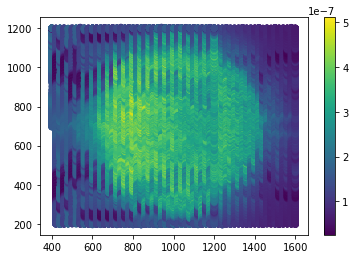

In [32]:
plt.scatter(f10.xpos,f10.ypos,c=f10.amps*-1)
plt.colorbar()

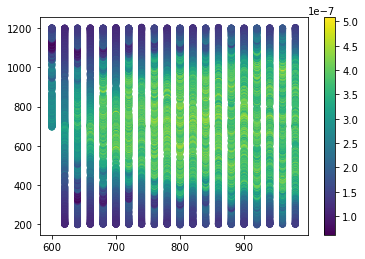

In [36]:
ff = f10[f10.Electrometer==4]
plt.scatter(ff.xpos,ff.ypos,c=ff.amps*-1)
plt.colorbar()

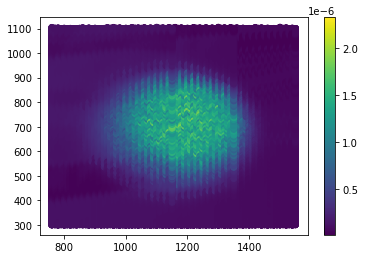

In [62]:
plt.scatter(f7.xpos,f7.ypos,c=f7.amps*-1)
plt.colorbar()

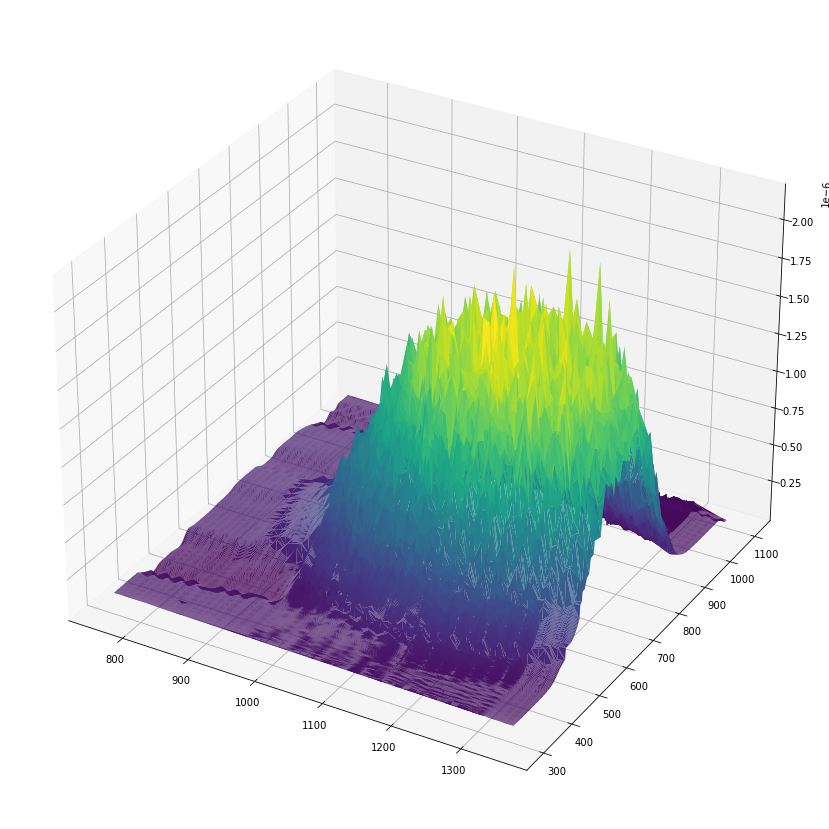

In [148]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(15,15))
ax = plt.axes(projection = '3d')
ax.plot_trisurf(f6.xpos,f6.ypos, f6.amps*-1,cmap = 'viridis')

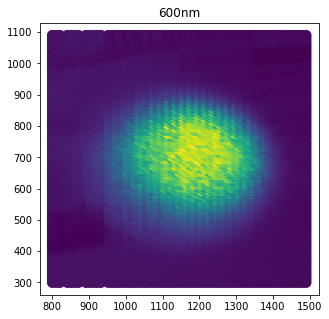

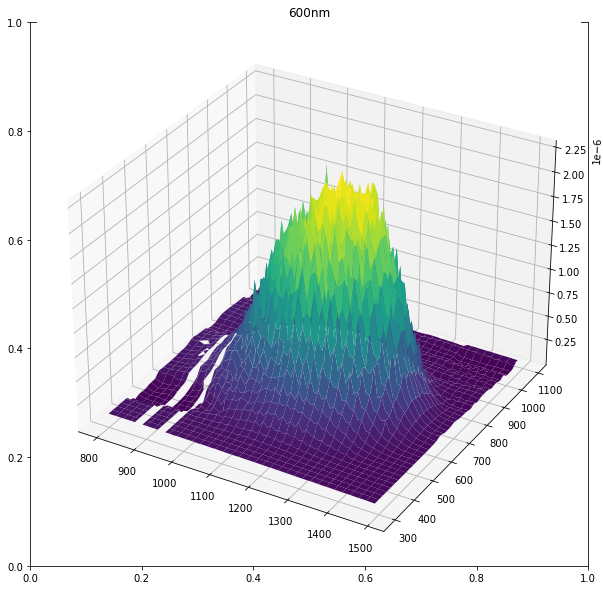

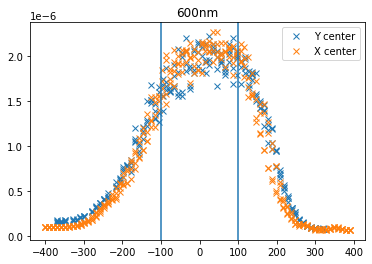

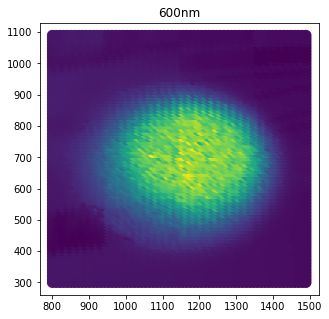

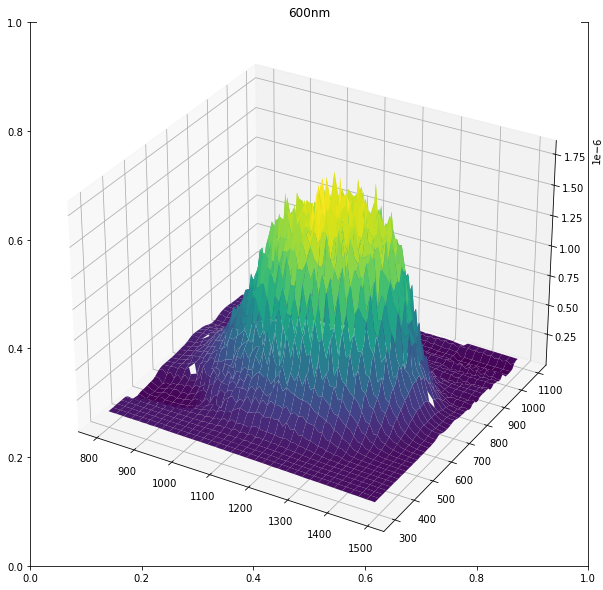

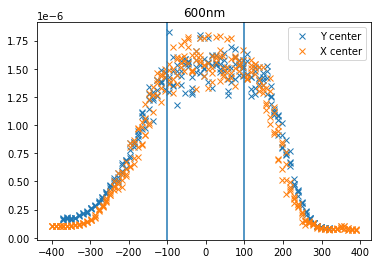

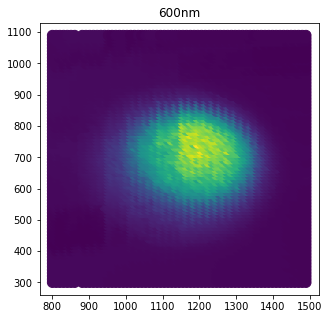

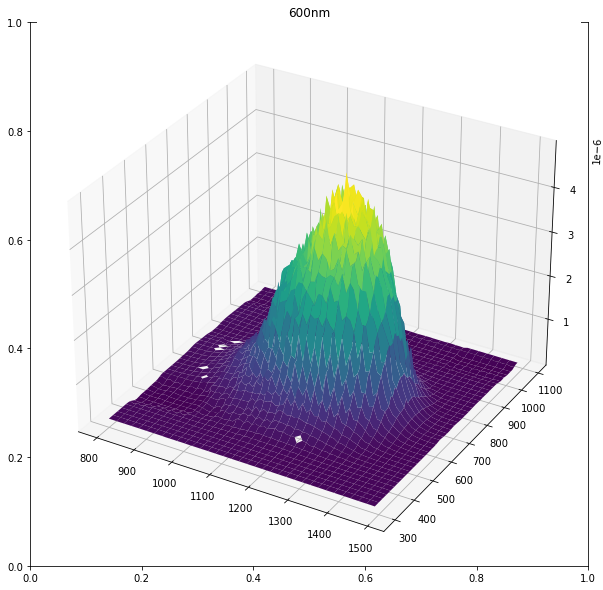

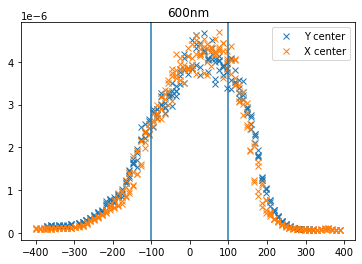

In [20]:
test_name = [600,600,600]
for i,test in enumerate([f9, f7, f2]):
    x = test.xpos
    y = test.ypos
    binx = np.linspace(800,1500,(1500-800)//10)
    biny = np.linspace(300,1100,(1100-300)//10)
    val,xedge,yedge,binn = stats.binned_statistic_2d(x, y, test.amps*-1, 'mean', bins=[binx, biny])
    plt.figure(figsize=(5,5))
    xx,yy = np.meshgrid(xedge[:-1],yedge[:-1])
    plt.scatter(xx,yy,c=val.T,s=100)
    plt.title('{}nm'.format(test_name[i]))
    plt.subplots(figsize=(10,10))
    ax = plt.axes(projection = '3d')
    ax.plot_surface(xx,yy,val.T,cmap = 'viridis')
    ax.set_title('{}nm'.format(test_name[i]))
    xxx = xx.flatten()
    yyy = yy.flatten()
    zzz = val.T.flatten()

    center_y = np.where(np.abs(yyy-700)<20)
    center_x = np.where(np.abs(xxx-1170)<20)
    plt.figure()
    plt.plot(xxx[center_y]-1170, zzz[center_y],'x',label='Y center')
    plt.plot(yyy[center_x]-700, zzz[center_x],'x', label='X center')
    plt.axvline(-100)
    plt.axvline(100)
    plt.title('{}nm'.format(test_name[i]))
    plt.legend()

In [72]:
StabilityData_600 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_stability_may23.csv')
StabilityData_600_2 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_stability_scan_may24.csv')
StabilityData_600_3 = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_stability_scan_may25.csv')
StabilityData_600_scrambler = pd.read_csv('/home/parfa30/DATA/ScanData/600nm_stability_scramble_jun1.csv')

In [73]:
s0 = StabilityData_600_scrambler[StabilityData_600_scrambler.amps < 0]

In [74]:
s0['meas_time'] = pd.to_datetime(s0['meas_time'])

In [75]:
np.unique(s0.step)

array([1, 2, 3, 4])

In [76]:
s0_1 = s0[s0.Electrometer==2]
s0_2 = s0[s0.Electrometer==4]
s0_3 = s0[s0.Electrometer==5]

In [66]:
s00 = s0[s0.step==1]

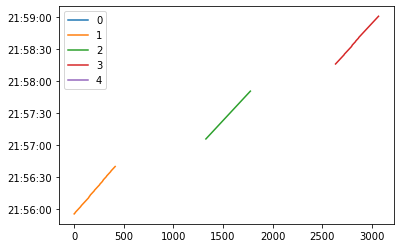

In [63]:
for step in range(5):
    plt.plot(s0_1[s0_1.step==step].meas_time, label=step)
plt.legend()

[2.1202950815327805e-08, 2.095083208315724e-08, 2.084371432181026e-08, 2.0947147740625988e-08]
[1.3821039502660163e-08, 1.385234824616677e-08, 1.3729703956251697e-08, 1.373837954211301e-08]
[1.932091472379753e-08, 1.9144861927997934e-08, 1.8932355413657627e-08]


Text(0.5, 1.0, 'Stability of laser illumination (std of mean from 4 ~45 sec. consecutive measurements)')

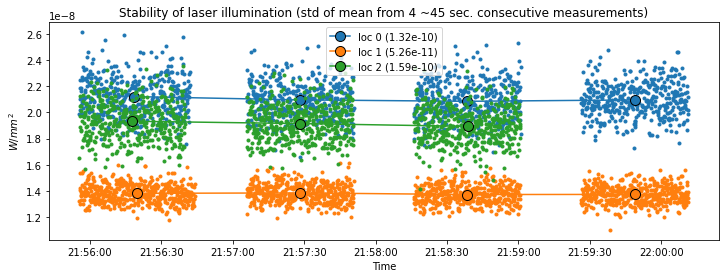

In [86]:
plt.figure(figsize=(12,4))
cc = ['C0','C1','C2']
for i,s0_ in enumerate([s0_2, s0_3, s0_1]):
    plt.plot(s0_.meas_time, watts_per_mm2(s0_.amps*-1),'.',c=cc[i])
    means = []
    times = []
    for step in np.unique(s0_.step):
        ss = s0_[s0_.step == step]
        means.append(watts_per_mm2(np.mean(ss.amps)*-1))
        times.append(np.mean(ss.meas_time))
    plt.plot(times, means,'o-',c=cc[i],markersize=10,markeredgecolor='k',label='loc {} ({:.2e})'.format(i, np.std(means)))
    print(means)
plt.legend()
plt.xlabel("Time")
plt.ylabel("$W/mm^{2}$")
plt.title("Stability of laser illumination (std of mean from 4 ~45 sec. consecutive measurements)") 

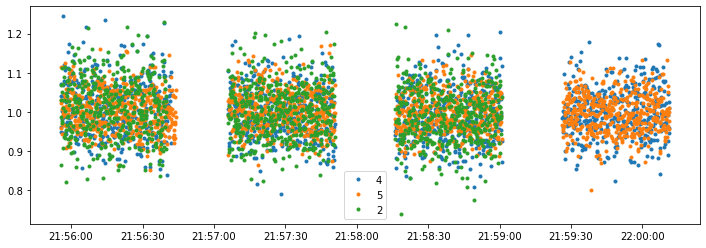

In [65]:
plt.figure(figsize=(12,4))
plt.plot(s0_2.meas_time, watts_per_mm2(s0_2.amps*-1)/np.mean(watts_per_mm2(s0_2.amps*-1)),'.',label='4')
plt.plot(s0_3.meas_time, watts_per_mm2(s0_3.amps*-1)/np.mean(watts_per_mm2(s0_3.amps*-1)),'.',label='5')
plt.plot(s0_1.meas_time, watts_per_mm2(s0_1.amps*-1)/np.mean(watts_per_mm2(s0_1.amps*-1)),'.',label='2')
# for s0_ in [s0_2, s0_3, s0_1]:
#     means = []
#     times = []
#     for step in np.unique(s0_.step):
#         ss = s0_[s0_.step == step]
#         means.append(watts_per_mm2(np.mean(ss.amps)*-1))
#         times.append(np.mean(ss.meas_time))
#     plt.plot(times, means,'o-')
plt.legend()

NameError: name 'vals' is not defined

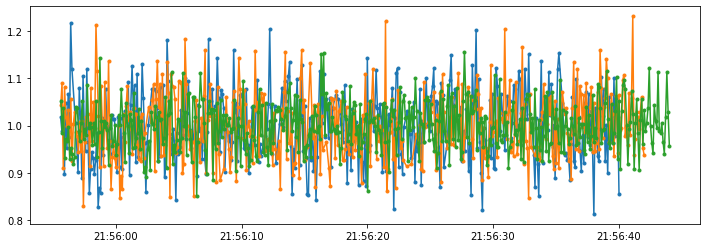

In [57]:
step = 1
plt.figure(figsize=(12,4))
for i, s0_ in enumerate([s0_1, s0_2, s0_3]):
    s00_ = s0_[s0_.step == 1]
    plt.plot(s00_.meas_time, watts_per_mm2(s00_.amps*-1)/np.mean(watts_per_mm2(s00_.amps*-1)),'.-', label=i)
plt.plot(times, vals/np.mean(vals),'kx',label='mean 0')
plt.legend()


In [78]:
s00_1 = s0_1[s0_1.step == 1]
s00_2 = s0_2[s0_2.step == 1]
s00_3 = s0_3[s0_3.step == 1]

In [79]:
s00_1.reset_index(inplace=True)
s00_2.reset_index(inplace=True)
s00_3.reset_index(inplace=True)

In [80]:
max(s00_1.meas_time)-min(s00_1.meas_time)

Timedelta('0 days 00:00:44.429190')

In [31]:
max(s00_1[0:19].meas_time) - min(s00_1[0:19].meas_time)

Timedelta('0 days 00:00:02.083258')

In [34]:
45/2.

22.5

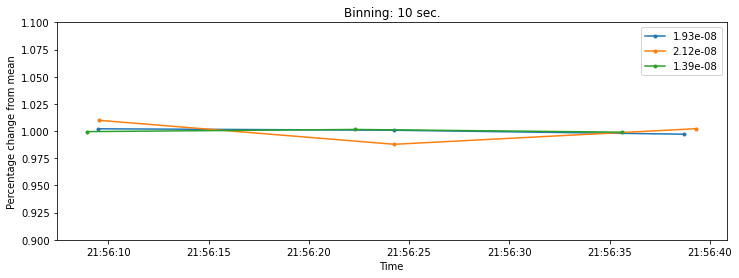

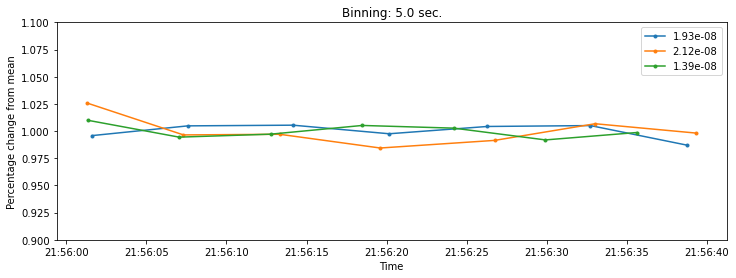

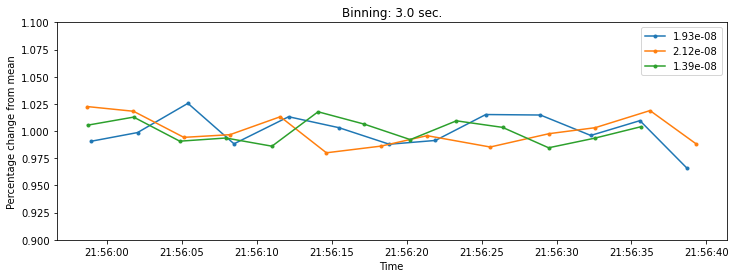

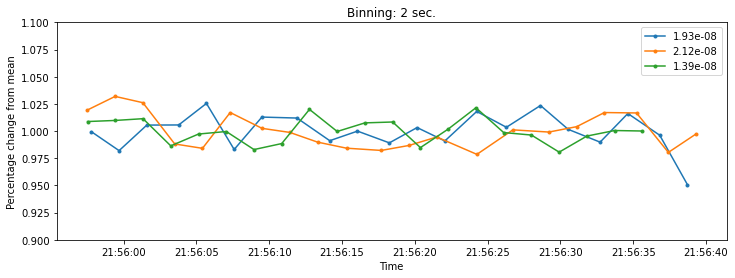

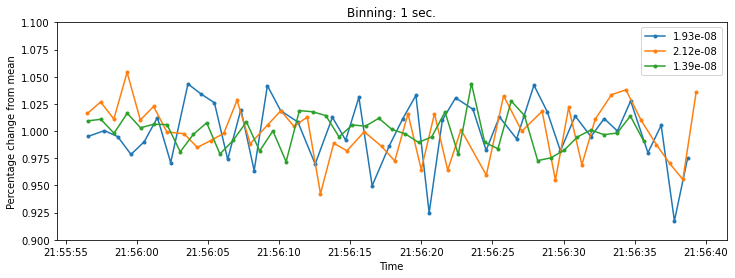

In [81]:
for binsize in [10,5.,3.,2,1]:
    bins = np.linspace(0,400,int(44/binsize))
    plt.figure(figsize=(12,4))
    for s00_ in [s00_1, s00_2, s00_3]:
        tt = interpolate.interp1d(s00_.index, Time(s00_.meas_time).jd)
        bin_means, bin_edges, binnumber = stats.binned_statistic(s00_.index, watts_per_mm2(s00_.amps*-1), statistic='mean', bins=bins)
        tt_ = Time(tt(bin_edges[1:]),format='jd').datetime
        plt.plot(tt_,bin_means/np.mean(bin_means),'.-', label='{:.2e}'.format(np.mean(bin_means)))
    plt.title('Binning: {} sec.'.format(binsize))
    plt.ylim(0.9,1.1)
    plt.xlabel("Time")
    plt.ylabel("Percentage change from mean")
    plt.legend()

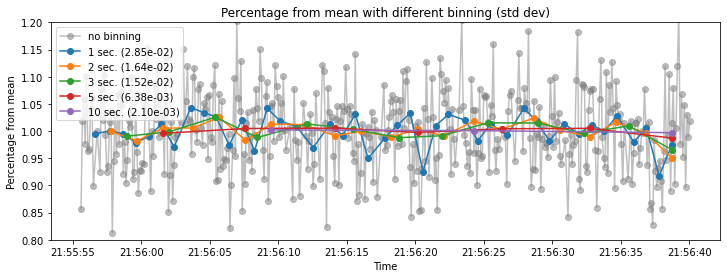

In [82]:
plt.figure(figsize=(12,4))
for s00_ in [s00_1]:
    plt.plot(s00_.meas_time, watts_per_mm2(s00_.amps*-1)/np.mean(watts_per_mm2(s00_.amps*-1)),'o-',c='gray',alpha=0.5, label='no binning')
    for binsize in [1,2,3,5,10]:
        bins = np.linspace(0,400,int(44/binsize))
        tt = interpolate.interp1d(s00_.index, Time(s00_.meas_time).jd)
        bin_means, bin_edges, binnumber = stats.binned_statistic(s00_.index, watts_per_mm2(s00_.amps*-1), statistic='mean', bins=bins)
        tt_ = Time(tt(bin_edges[1:]),format='jd').datetime
        plt.plot(tt_,bin_means/np.mean(bin_means),'o-', label='{} sec. ({:.2e})'.format(binsize, np.std(bin_means/np.mean(bin_means))))
    plt.title("Percentage from mean with different binning (std dev)")
    plt.ylim(0.8,1.2)
    plt.xlabel("Time")
    plt.ylabel("Percentage from mean")
    plt.legend()

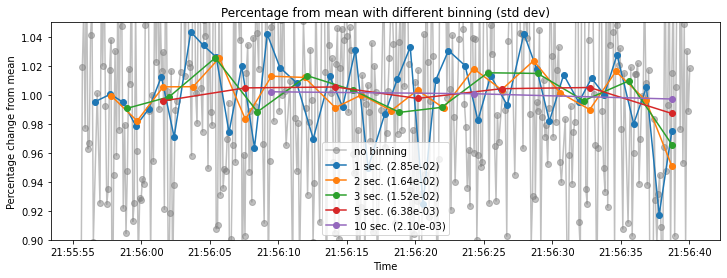

In [84]:
plt.figure(figsize=(12,4))
plt.plot(s00_.meas_time, watts_per_mm2(s00_.amps*-1)/np.mean(watts_per_mm2(s00_.amps*-1)),'o-',c='gray',alpha=0.5, label='no binning')
for binsize in [1,2,3,5,10]:
    bins = np.linspace(0,400,int(44/binsize))
    for s00_ in [s00_1]:
        tt = interpolate.interp1d(s00_.index, Time(s00_.meas_time).jd)
        bin_means, bin_edges, binnumber = stats.binned_statistic(s00_.index, watts_per_mm2(s00_.amps*-1), statistic='mean', bins=bins)
        tt_ = Time(tt(bin_edges[1:]),format='jd').datetime
        plt.plot(tt_,bin_means/np.mean(bin_means),'o-', label='{} sec. ({:.2e})'.format(binsize, np.std(bin_means/np.mean(bin_means))))
    plt.title("Percentage from mean with different binning (std dev)")
    plt.ylim(0.9,1.05)
    plt.xlabel("Time")
    plt.ylabel("Percentage change from mean")
    plt.legend()

In [87]:
times = []
vals = []
for i in range(s00_1.shape[0]//20):
    xx = s00_1.iloc[i*20:(i+1)*20]
    times.append(np.mean(xx.meas_time))
    vals.append(np.mean(watts_per_mm2(xx.amps*-1)))

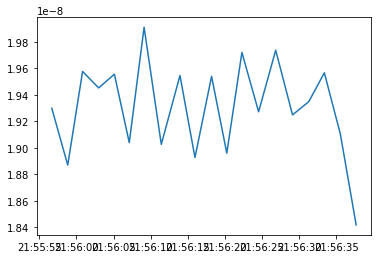

In [97]:
plt.plot(times,vals)

In [61]:
np.mean(s0_2.amps)*-1, np.std(s0_2.amps), np.std(s0_2.amps)/np.mean(s0_2.amps)*-1

(1.3764969319271333e-06, 1.6121958998163578e-07, 0.11712310157925593)

In [62]:
np.mean(s0_3.amps)*-1, np.std(s0_3.amps), np.std(s0_3.amps)/np.mean(s0_3.amps)*-1,

(4.6618266800401197e-07, 2.7963689419452868e-08, 0.059984403837193306)

In [63]:
np.mean(s0_1.amps)*-1, np.std(s0_1.amps), np.std(s0_1.amps)/np.mean(s0_1.amps)*-1,

(7.995784099616847e-07, 8.83358464452771e-08, 0.1104780286019855)

In [192]:
means = []
times = []
sss = s0_2[s0_2.step==1]
n = 10
for x in range(len(sss)//n):
    ssss = sss.iloc[x*n:(x*n)+n]
    means.append(np.mean(ssss.amps*-1))

In [193]:
means

[1.3321400000000002e-06,
 1.3162499999999999e-06,
 1.39738e-06,
 1.31649e-06,
 1.30975e-06,
 1.3302200000000001e-06,
 1.3438499999999998e-06,
 1.37534e-06,
 1.2777599999999998e-06,
 1.3543300000000003e-06,
 1.33778e-06,
 1.36031e-06]